In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")


In [4]:
b1 = pd.read_csv("api_data_aadhar_demographic_0_500000.csv")
b2 = pd.read_csv("api_data_aadhar_demographic_500000_1000000.csv")
b3 = pd.read_csv("api_data_aadhar_demographic_1000000_1500000.csv")
b4 = pd.read_csv("api_data_aadhar_demographic_1500000_2000000.csv")

demo_df = pd.concat([b1, b2, b3, b4], ignore_index=True)
demo_df.shape
demo_df.head()
demo_df.info()
demo_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 6 columns):
 #   Column         Dtype 
---  ------         ----- 
 0   date           object
 1   state          object
 2   district       object
 3   pincode        int64 
 4   demo_age_5_17  int64 
 5   demo_age_17_   int64 
dtypes: int64(3), object(3)
memory usage: 91.6+ MB


date             0
state            0
district         0
pincode          0
demo_age_5_17    0
demo_age_17_     0
dtype: int64

In [5]:
demo_df["date"] = pd.to_datetime(demo_df["date"], dayfirst=True, errors="coerce")
demo_df.fillna(0, inplace=True)

demo_df.head()

,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,2025-03-01,Uttar Pradesh,Gorakhpur,273213,49,529
1,2025-03-01,Andhra Pradesh,Chittoor,517132,22,375
2,2025-03-01,Gujarat,Rajkot,360006,65,765
3,2025-03-01,Andhra Pradesh,Srikakulam,532484,24,314
4,2025-03-01,Rajasthan,Udaipur,313801,45,785


In [6]:
demo_df["total_population"] = (
    demo_df["demo_age_5_17"] + demo_df["demo_age_17_"]
)


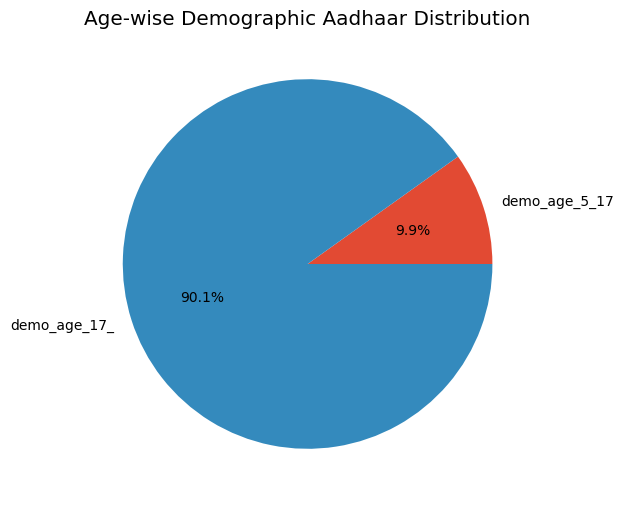

In [8]:
age_demo = demo_df[["demo_age_5_17", "demo_age_17_"]].sum()

age_demo.plot(kind="pie", autopct="%1.1f%%", figsize=(6,6))
plt.title("Age-wise Demographic Aadhaar Distribution")
plt.ylabel("")
plt.show()


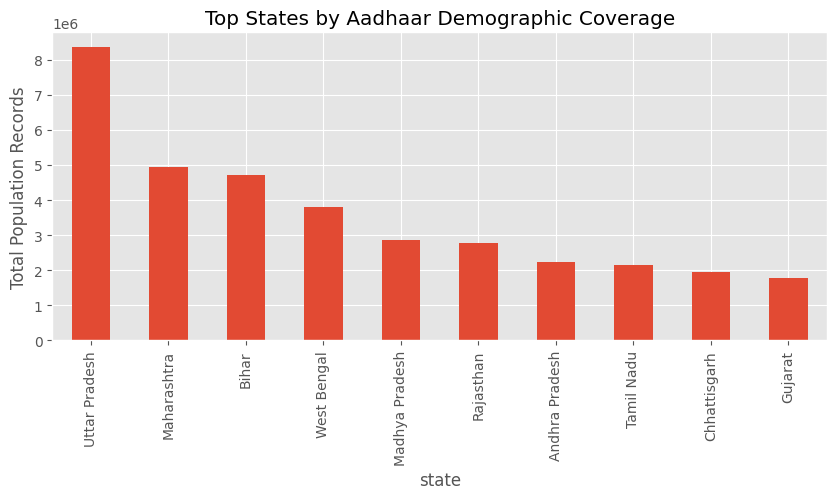

In [9]:
state_demo = (
    demo_df.groupby("state")["total_population"]
    .sum()
    .sort_values(ascending=False)
)

state_demo.head(10).plot(kind="bar", figsize=(10,4))
plt.title("Top States by Aadhaar Demographic Coverage")
plt.ylabel("Total Population Records")
plt.show()


In [10]:
demo_df["adult_ratio"] = (
    demo_df["demo_age_17_"] / demo_df["total_population"]
).replace([np.inf, np.nan], 0)

adult_ratio_state = demo_df.groupby("state")["adult_ratio"].mean()

adult_ratio_state.sort_values().head(10)


state
Dadra and Nagar Haveli    0.757132
Ladakh                    0.798491
Manipur                   0.814680
Arunachal Pradesh         0.818847
Puducherry                0.822215
Tamil Nadu                0.833279
Telangana                 0.840780
Lakshadweep               0.841359
Daman and Diu             0.841823
Andhra Pradesh            0.844519
Name: adult_ratio, dtype: float64

In [11]:
Q1 = demo_df["total_population"].quantile(0.25)
Q3 = demo_df["total_population"].quantile(0.75)
IQR = Q3 - Q1

demo_df["anomaly"] = (
    demo_df["total_population"] > (Q3 + 1.5 * IQR)
)

demo_df[demo_df["anomaly"]].head()


,date,state,district,pincode,demo_age_5_17,demo_age_17_,total_population,adult_ratio,anomaly
0,2025-03-01,Uttar Pradesh,Gorakhpur,273213,49,529,578,0.915225,True
1,2025-03-01,Andhra Pradesh,Chittoor,517132,22,375,397,0.944584,True
2,2025-03-01,Gujarat,Rajkot,360006,65,765,830,0.921687,True
3,2025-03-01,Andhra Pradesh,Srikakulam,532484,24,314,338,0.928994,True
4,2025-03-01,Rajasthan,Udaipur,313801,45,785,830,0.945783,True


In [12]:
low_coverage = (
    demo_df.groupby("district")["total_population"]
    .sum()
    .sort_values()
    .head(10)
)

low_coverage


district
100000                   1
Bijapur(KAR)             1
Jyotiba Phule Nagar *    1
Bandipur                 1
Udupi *                  1
Bally Jagachha           1
Chandauli *              1
Balianta                 1
Bhadrak(R)               1
Dist : Thane             1
Name: total_population, dtype: int64

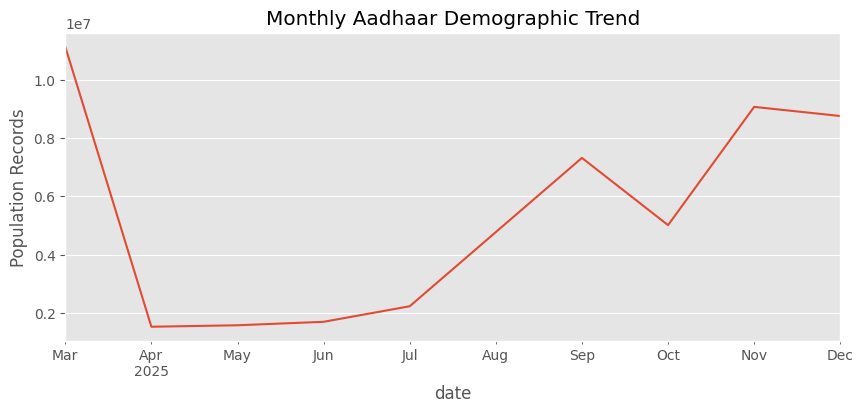

In [13]:
monthly_demo = (
    demo_df.groupby(demo_df["date"].dt.to_period("M"))["total_population"]
    .sum()
)

monthly_demo.plot(figsize=(10,4))
plt.title("Monthly Aadhaar Demographic Trend")
plt.ylabel("Population Records")
plt.show()


In [14]:
low_coverage.to_csv("demographic_low_coverage.csv")


In [16]:
demo_df["total_population"] = (
    demo_df["demo_age_5_17"] + demo_df["demo_age_17_"]
)

demo_summary = demo_df.groupby("district").agg(
    total_population=("total_population", "sum")
).reset_index()

demo_summary.to_csv("demo_summary.csv", index=False)
